In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import glob

import gc

In [2]:
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 100)

In [3]:
n_pred = 20 # sessionごとに予測するaidの数（固定）
weight = {"clicks": 0.1, "carts": 0.3, "orders": 0.6}

event_type = "orders"

path_input_feat = {}
path_input_label = {}
for i in ["train1"]:
    path_input_feat[i] = f"/kaggle/input/otto-make-data-feature/feature_label_{i}_{{}}_{{}}.pickle"
    path_input_label[i] = f"/kaggle/input/otto-make-data-feature/n_ground_truth_{i}_{event_type}.csv"

In [4]:
list_files = glob.glob(path_input_feat["train1"].format('feat','*'))
len(list_files)

15

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
rand = 64

n_splits = 5
n_round = 1000

lgb_params = {
    "objective": "lambdarank",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 80,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.05,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 100,
    "lambda_l1": 0,
    "lambda_l2": 50,
    "random_state": rand,
    "metric": "map",
    "eval_at": [20,50],
    "verbose": -1
}

# train

In [7]:
# データ読み込み
df_Xy = []
for n_chunk in range(len(list_files)):
    feat = pd.read_pickle(path_input_feat["train1"].format("feat", n_chunk))
    label = pd.read_pickle(path_input_feat["train1"].format(event_type, n_chunk))
    df_Xy.append(pd.concat([feat,label], axis = 1))
df_Xy = pd.concat(df_Xy)
    
# df_Xy = pd.read_csv(path_input_feat["train1"], dtype = np.int32)
df_Xy = reduce_mem_usage(df_Xy)
display(df_Xy)
df_X = df_Xy.drop([f"label_{event_type}"], axis = 1)
df_y = df_Xy[f"label_{event_type}"]
df_session = df_Xy["session"]

display(df_y.value_counts())

del df_Xy, feat, label
gc.collect()

Mem. usage decreased to 1578.91 Mb (0.0% reduction)


,session,n_type_all,n_type_clicks,n_type_carts,n_type_orders,rate_type_clicks,rate_type_carts,rate_type_orders,n_type_all_aid,n_type_clicks_aid,...,n_alltypes_allses_lastweek,n_clicks_allses_diff,n_clicks_allses_diffrate,n_carts_allses_diff,n_carts_allses_diffrate,n_orders_allses_diff,n_orders_allses_diffrate,n_alltypes_allses_diff,n_alltypes_allses_diffrate,label_orders
0,8643220,1,1,0,0,1.0,0.0,0.0,0,0,...,675,-358,0.438477,-22,0.210571,-8,0.105286,-388,0.424805,0
1,8643220,1,1,0,0,1.0,0.0,0.0,0,0,...,1106,-713,0.316895,-35,0.236572,-13,0.181763,-761,0.311768,0
2,8643220,1,1,0,0,1.0,0.0,0.0,0,0,...,1364,-654,0.440918,-110,0.250732,-38,0.189453,-802,0.411865,0
3,8643220,1,1,0,0,1.0,0.0,0.0,0,0,...,4,43,10.445312,3,6.000000,1,2.000000,47,11.335938,0
4,8643220,1,1,0,0,1.0,0.0,0.0,0,0,...,26,-18,0.274414,-1,0.000000,0,0.000000,-19,0.264160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336832,11098509,1,1,0,0,1.0,0.0,0.0,0,0,...,592,-146,0.720703,-15,0.692871,-16,0.108093,-177,0.700195,0
1336833,11098509,1,1,0,0,1.0,0.0,0.0,0,0,...,105,-50,0.476562,-2,0.666504,-2,0.000000,-54,0.483398,0
1336834,11098509,1,1,0,0,1.0,0.0,0.0,0,0,...,70,-39,0.357666,-5,0.353027,-1,0.000000,-45,0.354492,0
1336835,11098509,1,1,0,0,1.0,0.0,0.0,0,0,...,292,23,1.082031,2,1.111328,-3,0.461426,22,1.073242,0


0    21817307
1      257504
Name: label_orders, dtype: int64

45

In [8]:
# Group-K-Fold modeling
list_model = []
# shuffleしたほうが良い？
folds = GroupKFold(n_splits = n_splits)
df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(df_X,df_y, df_session):
    X_tr, X_va, y_tr, y_va = df_X.iloc[tr_idx], df_X.iloc[va_idx], df_y.iloc[tr_idx], df_y.iloc[va_idx] 
    tr_g = X_tr.groupby(["session"])["n_type_all"].count().values
    va_g = X_va.groupby(["session"])["n_type_all"].count().values
    X_tr = X_tr.drop(["session"], axis = 1)
    X_va = X_va.drop(["session"], axis = 1)
    d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False, group = tr_g)
    d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False, group = va_g)
    model = lgb.train(
        lgb_params,
        train_set = d_tr,
        num_boost_round = n_round,
        valid_sets = [d_tr,d_va],
        callbacks = [
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(50),
        ]
    )
    list_model.append(model)
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_tr.columns.values
    df_fimp_1["importance"] = model.feature_importance()

    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del X_tr, X_va, y_tr, y_va, d_tr, d_va, model
    gc.collect()

# save model
pd.to_pickle(list_model,f"lgbranker_models_{event_type}.pkl")

Training until validation scores don't improve for 20 rounds
[50]	training's map@20: 0.993434	training's map@50: 0.993444	valid_1's map@20: 0.993102	valid_1's map@50: 0.993113
[100]	training's map@20: 0.993692	training's map@50: 0.993701	valid_1's map@20: 0.99315	valid_1's map@50: 0.99316
Early stopping, best iteration is:
[89]	training's map@20: 0.993645	training's map@50: 0.993654	valid_1's map@20: 0.993168	valid_1's map@50: 0.993178
Training until validation scores don't improve for 20 rounds
[50]	training's map@20: 0.993427	training's map@50: 0.993437	valid_1's map@20: 0.993166	valid_1's map@50: 0.993175
[100]	training's map@20: 0.993659	training's map@50: 0.993668	valid_1's map@20: 0.993233	valid_1's map@50: 0.993242
[150]	training's map@20: 0.99385	training's map@50: 0.993859	valid_1's map@20: 0.993255	valid_1's map@50: 0.993262
Early stopping, best iteration is:
[154]	training's map@20: 0.993859	training's map@50: 0.993868	valid_1's map@20: 0.993261	valid_1's map@50: 0.993269
Tr

In [9]:
del df_X, df_y
gc.collect()

57

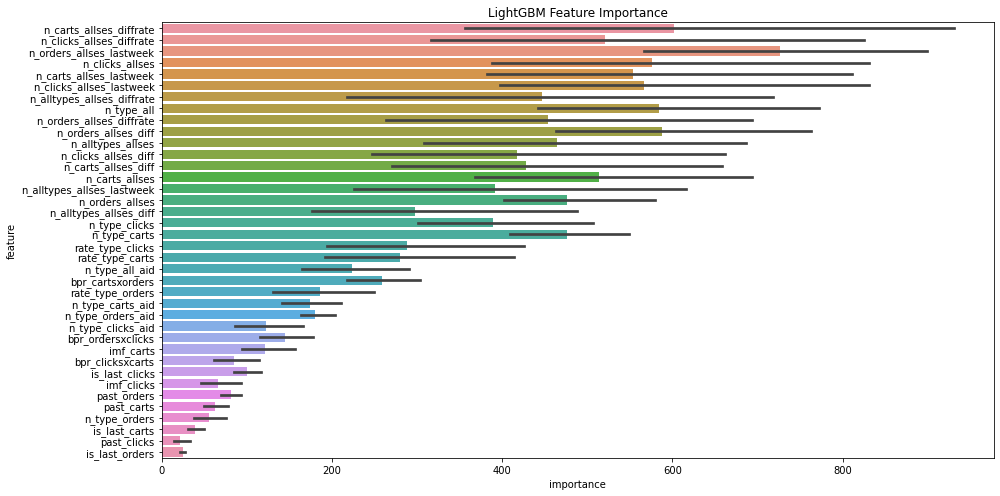

In [10]:
plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()